## Single-cell rna demo

In [67]:
import json

import pandas as pd
import numpy as np

from scipy.io import mmread

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer

import umap
import umap.plot as uplot

from kneed import KneeLocator
import random

random.seed(12)

sns.set_theme()

## Load the data

Single-cell RNA sequencing (scRNA-seq) is a technique used to study the gene expression patterns of individual cells. 


In [68]:
# Load the dataset
cell_names_path = 'data/pbmc_3k/hg19/barcodes.tsv'
gene_names_path = 'data/pbmc_3k/hg19/genes.tsv'
data_path = 'data/pbmc_3k/hg19/matrix.mtx'

cell_names = pd.read_csv(cell_names_path, sep='\t', header=None)[0]
gene_names = pd.read_csv(gene_names_path, sep='\t', header=None)[1]

In [69]:
# Load cell annotations
cell_annotations_path = 'data/pbmc_3k/pmbc_3k_cell_types.json'
fle = open(cell_annotations_path, 'r')
cell_type_dict = json.load(fle)
fle.close()

In [70]:
cell_type_dict

{'AAACATACAACCAC-1': 'Memory CD4 T',
 'AAACATTGAGCTAC-1': 'B-cells',
 'AAACATTGATCAGC-1': 'Memory CD4 T',
 'AAACCGTGCTTCCG-1': 'CD14+ Mono',
 'AAACCGTGTATGCG-1': 'NK cells',
 'AAACGCACTGGTAC-1': 'Memory CD4 T',
 'AAACGCTGACCAGT-1': 'CD8 T',
 'AAACGCTGGTTCTT-1': 'CD8 T',
 'AAACGCTGTAGCCA-1': 'Naive CD4 T',
 'AAACGCTGTTTCTG-1': 'FCGR3A+ Mono',
 'AAACTTGAAAAACG-1': 'B-cells',
 'AAACTTGATCCAGA-1': 'Naive CD4 T',
 'AAAGAGACGAGATA-1': 'Naive CD4 T',
 'AAAGAGACGCGAGA-1': 'CD14+ Mono',
 'AAAGAGACGGACTT-1': 'Naive CD4 T',
 'AAAGAGACGGCATT-1': 'Naive CD4 T',
 'AAAGCAGATATCGG-1': 'CD14+ Mono',
 'AAAGCCTGTATGCG-1': 'Memory CD4 T',
 'AAAGGCCTGTCTAG-1': 'B-cells',
 'AAAGTTTGATCACG-1': 'B-cells',
 'AAAGTTTGGGGTGA-1': 'B-cells',
 'AAAGTTTGTAGAGA-1': 'Naive CD4 T',
 'AAAGTTTGTAGCGT-1': 'CD14+ Mono',
 'AAATCAACAATGCC-1': 'B-cells',
 'AAATCAACACCAGT-1': 'Naive CD4 T',
 'AAATCAACCAGGAG-1': 'Naive CD4 T',
 'AAATCAACCCTATT-1': 'FCGR3A+ Mono',
 'AAATCAACGGAAGC-1': 'Naive CD4 T',
 'AAATCAACTCGCAA-1': 'Memory 

In [71]:
# Show cell names
cell_names.head()

0    AAACATACAACCAC-1
1    AAACATTGAGCTAC-1
2    AAACATTGATCAGC-1
3    AAACCGTGCTTCCG-1
4    AAACCGTGTATGCG-1
Name: 0, dtype: object

In [72]:
# Show gene names
gene_names.head()

0      MIR1302-10
1         FAM138A
2           OR4F5
3    RP11-34P13.7
4    RP11-34P13.8
Name: 1, dtype: object

In [73]:
# Load expression matrix
expression_mtx = mmread(data_path)

In [74]:
# Show shapes
print('Expression shape : {}'.format(expression_mtx.shape))
print('Num cells : {}'.format(cell_names.shape[0]))
print('Num genes : {}'.format(gene_names.shape[0]))

Expression shape : (32738, 2700)
Num cells : 2700
Num genes : 32738


In [75]:
# Create dataframe from sparse matrix
expression_df = pd.DataFrame.sparse.from_spmatrix(
    expression_mtx, 
    columns=cell_names.to_numpy(), 
    index=gene_names.to_numpy()
)

In [76]:
expression_df.iloc[1300:1320, 1100:1120]

,CCGCTATGTGCAAC-1,CCGCTATGTGCACA-1,CCGGTACTGTCCTC-1,CCGTACACAAGCAA-1,CCGTACACAGCGTT-1,CCGTACACGTCATG-1,CCGTACACGTTGGT-1,CCGTACACTAACGC-1,CCTAAACTTTCGTT-1,CCTAAGGACCCAAA-1,CCTAAGGACTAGCA-1,CCTAAGGAGGGCAA-1,CCTAAGGATGATGC-1,CCTAAGGATGTCAG-1,CCTACCGACTCTTA-1,CCTACCGAGGGATG-1,CCTAGAGAGGTGAG-1,CCTATAACCAAAGA-1,CCTATAACGAGACG-1,CCTATAACTCAGAC-1
RP11-131L23.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RP11-290M5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CYR61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RP11-290M5.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ZNHIT6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
COL24A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ODF2L,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0
CLCA2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CLCA1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CLCA4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Quality controll

In [77]:
# Get count sum for all genes/cels
gene_sum = expression_df.sum(axis=1)
cell_sum = expression_df.sum(axis=0)

# Remove all genes that are not expressed 
expression_df = expression_df.loc[
    gene_sum[gene_sum>3].index,
    cell_sum[cell_sum>10].index
].sparse.to_dense().T

KeyboardInterrupt: 

In [ ]:
expression_df.shape

(2700, 13164)

In [ ]:
expression_df.head()

,AL627309.1,RP11-206L10.2,LINC00115,NOC2L,KLHL17,PLEKHN1,HES4,RP11-54O7.11,ISG15,AGRN,...,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2,PNRC2,SRSF10,SRSF10
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Detect mitohondrial genes
mito_genes = [gene for gene in expression_df.columns if gene.startswith('MT-')]
mito_df = expression_df.loc[:, mito_genes]

# Calculate values that will be QC-ed
mito_df_sum = mito_df.sum(axis=1)
expression_df_sum = expression_df.sum(axis=1)
expression_df_num_genes = (expression_df>0).sum(axis=1)

percent_mt = mito_df_sum/expression_df_sum*100

In [ ]:
expression_df_num_genes

AAACATACAACCAC-1     779
AAACATTGAGCTAC-1    1352
AAACATTGATCAGC-1    1130
AAACCGTGCTTCCG-1     960
AAACCGTGTATGCG-1     521
                    ... 
TTTCGAACTCTCAT-1    1152
TTTCTACTGAGGCA-1    1223
TTTCTACTTCCTCG-1     622
TTTGCATGAGAGGC-1     452
TTTGCATGCCTCAC-1     723
Length: 2700, dtype: int64

In [ ]:
expression_df_sum

AAACATACAACCAC-1    2419.0
AAACATTGAGCTAC-1    4903.0
AAACATTGATCAGC-1    3148.0
AAACCGTGCTTCCG-1    2639.0
AAACCGTGTATGCG-1     980.0
                     ...  
TTTCGAACTCTCAT-1    3458.0
TTTCTACTGAGGCA-1    3442.0
TTTCTACTTCCTCG-1    1684.0
TTTGCATGAGAGGC-1    1022.0
TTTGCATGCCTCAC-1    1984.0
Length: 2700, dtype: float64

In [ ]:
percent_mt

AAACATACAACCAC-1    3.017776
AAACATTGAGCTAC-1    3.793596
AAACATTGATCAGC-1    0.889454
AAACCGTGCTTCCG-1    1.743085
AAACCGTGTATGCG-1    1.224490
                      ...   
TTTCGAACTCTCAT-1    2.111047
TTTCTACTGAGGCA-1    0.929692
TTTCTACTTCCTCG-1    2.197150
TTTGCATGAGAGGC-1    2.054795
TTTGCATGCCTCAC-1    0.806452
Length: 2700, dtype: float64

In [ ]:
# Function for median deviation calculation
def mad_qc(data, limit='upper'):

    # Calculate the median of the data
    median = np.median(data)

    # Calculate the absolute deviations from the median
    absolute_deviations = np.abs(data - median)

    # Calculate the median absolute deviation
    mad = np.median(absolute_deviations)
        
    if limit == 'upper':
        
        upper_limit = median + 3*mad
        return data > upper_limit
    
    elif limit =='lower':
        
        lower_limit = median - 3*mad
        return data < lower_limit

    else:
        raise Exception('Incorrect choice for limit')

In [ ]:
# Perform QC based on three criteria
mito_qc = mad_qc(percent_mt, limit='upper')
expression_sum_qc = mad_qc(expression_df_sum, limit='lower')
num_genes_qc = mad_qc(expression_df_num_genes, limit='lower')

final_qc = mito_qc | expression_sum_qc | num_genes_qc

In [ ]:
final_qc

AAACATACAACCAC-1    False
AAACATTGAGCTAC-1     True
AAACATTGATCAGC-1    False
AAACCGTGCTTCCG-1    False
AAACCGTGTATGCG-1    False
                    ...  
TTTCGAACTCTCAT-1    False
TTTCTACTGAGGCA-1    False
TTTCTACTTCCTCG-1    False
TTTGCATGAGAGGC-1    False
TTTGCATGCCTCAC-1    False
Length: 2700, dtype: bool

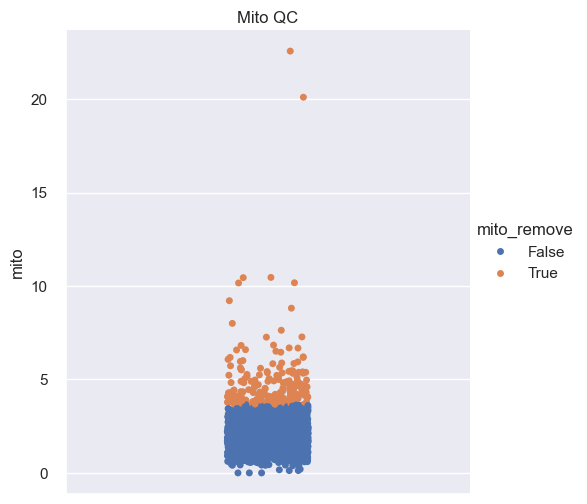

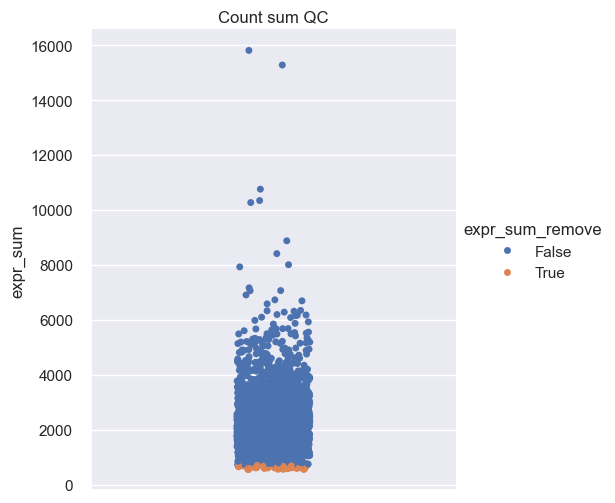

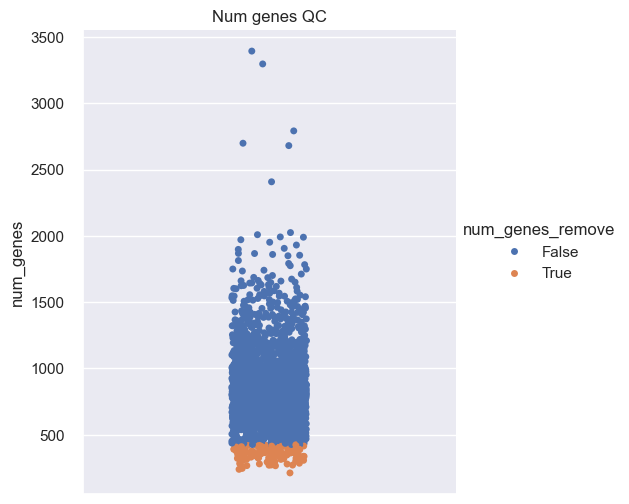

In [ ]:
# Concatenate all QC data and QC results into 
# a single dataframe
qc_df = pd.concat(
    [
        percent_mt.to_frame(name='mito'),
        expression_df_sum.to_frame(name='expr_sum'),
        expression_df_num_genes.to_frame(name='num_genes'),
        mito_qc.to_frame(name='mito_remove'),
        expression_sum_qc.to_frame(name='expr_sum_remove'),
        num_genes_qc.to_frame(name='num_genes_remove')
    ],
    axis=1
)

# Plot results
sns.catplot(qc_df, y='mito',hue='mito_remove').set(title='Mito QC')
sns.catplot(qc_df, y='expr_sum',hue='expr_sum_remove').set(title='Count sum QC')
sns.catplot(qc_df, y='num_genes',hue='num_genes_remove').set(title='Num genes QC')

In [ ]:
qc_df

,mito,expr_sum,num_genes,mito_remove,expr_sum_remove,num_genes_remove
AAACATACAACCAC-1,3.017776,2419.0,779,False,False,False
AAACATTGAGCTAC-1,3.793596,4903.0,1352,True,False,False
AAACATTGATCAGC-1,0.889454,3148.0,1130,False,False,False
AAACCGTGCTTCCG-1,1.743085,2639.0,960,False,False,False
AAACCGTGTATGCG-1,1.224490,980.0,521,False,False,False
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,2.111047,3458.0,1152,False,False,False
TTTCTACTGAGGCA-1,0.929692,3442.0,1223,False,False,False
TTTCTACTTCCTCG-1,2.197150,1684.0,622,False,False,False
TTTGCATGAGAGGC-1,2.054795,1022.0,452,False,False,False


In [ ]:
# Print number of eliminated and retained cells (data points)
final_qc.value_counts()

False    2411
True      289
Name: count, dtype: int64

In [ ]:
# Drop low quality cells
expression_df = expression_df.drop(
    index=final_qc[final_qc==True].index, 
    errors='ignore'
)

In [ ]:
# Remove cells without labels
cells_with_no_label = set(expression_df.index) - set(cell_type_dict.keys())
expression_df = expression_df.drop(index=cells_with_no_label)

### Normalization


In [ ]:
# Normalize expression of all genes in each cell by using sum of gene expressions in
# each cell
expression_df = expression_df.div(
    expression_df_sum[expression_df.index],
    axis=0
)*10000


Text(0, 0.5, 'Variance')

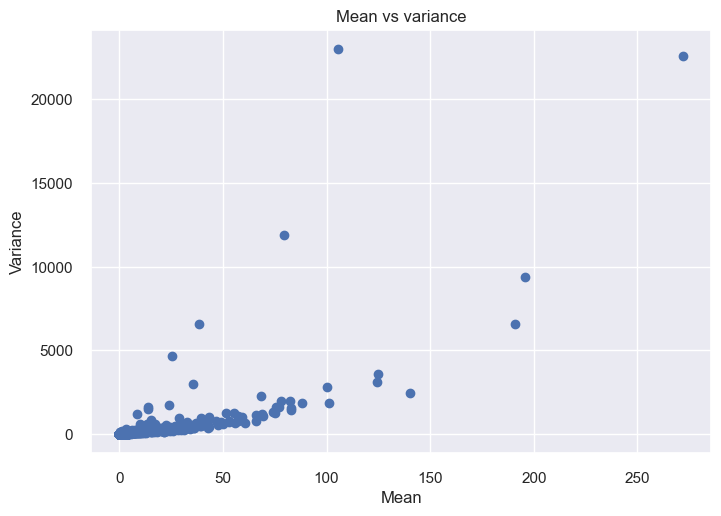

In [ ]:
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)

plt.scatter(gene_mean.to_numpy(), gene_var.to_numpy())
plt.title('Mean vs variance')
plt.xlabel('Mean')
plt.ylabel('Variance')

Text(0, 0.5, 'Count')

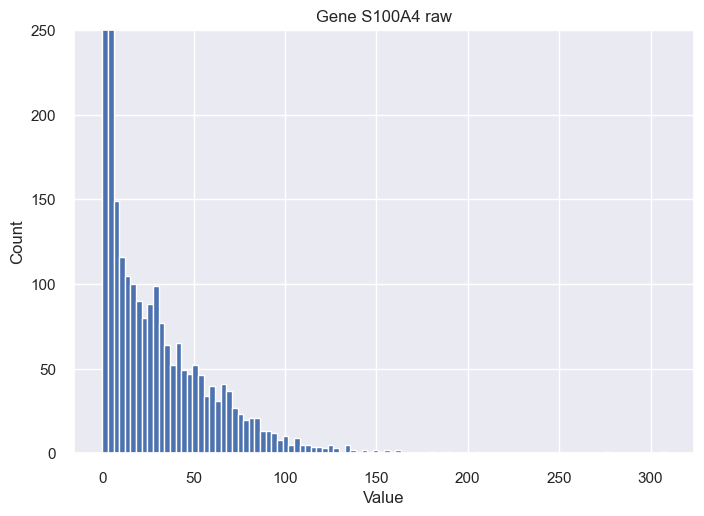

In [ ]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Gene S100A4 raw')
plt.xlabel('Value')
plt.ylabel('Count')

In [ ]:
# Log normalize the data
expression_df = np.log(expression_df + 1)

full_expression_df = expression_df.copy()

Text(0, 0.5, 'Log - Variance')

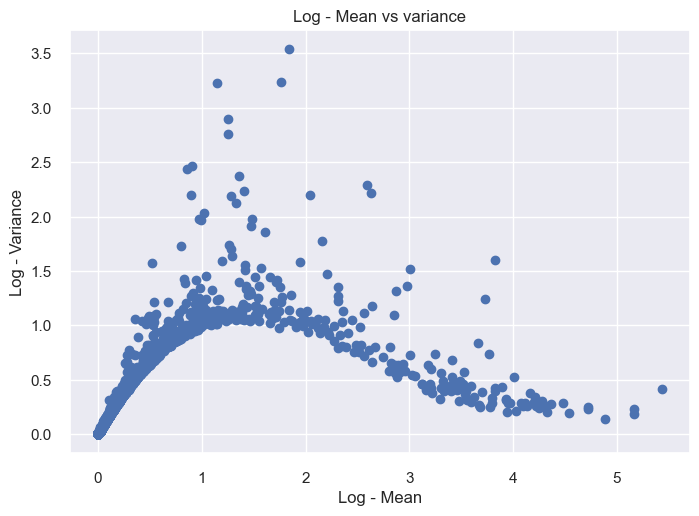

In [ ]:
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)


plt.scatter(gene_mean.to_numpy(), gene_var.to_numpy())
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')

Text(0, 0.5, 'Log - Count')

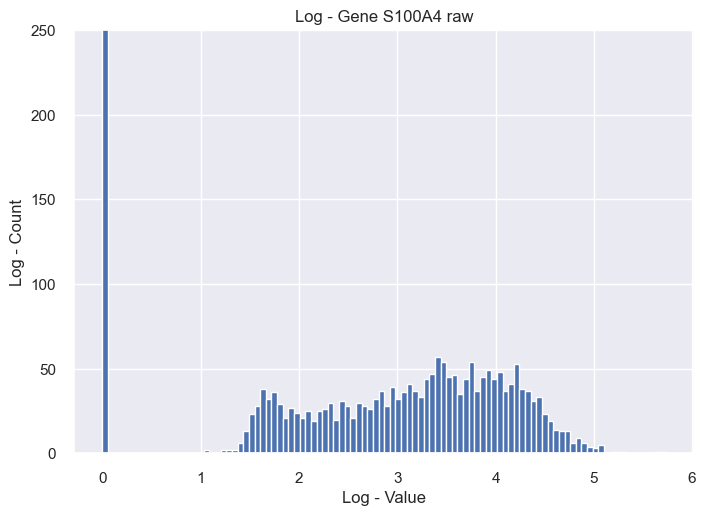

In [ ]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Log - Gene S100A4 raw')
plt.xlabel('Log - Value')
plt.ylabel('Log - Count')

### Feature selection

In [ ]:
# Add everything to data frame
gene_df = pd.concat([gene_mean, gene_var], axis=1)
gene_df.columns = ['mean', 'var']

# Bin the data
num_bins = 20
bin_labels = [i for i in range(num_bins)]
gene_df['bin'] = pd.cut(gene_df['mean'], bins=num_bins, labels=bin_labels)

In [ ]:
gene_df['bin'].value_counts()

bin
0     11846
1       752
2       201
3       106
4        55
5        36
6        25
13       17
10       17
8        17
7        17
12       16
9        14
11       13
15       12
14       11
16        3
17        3
19        3
18        0
Name: count, dtype: int64

Text(0, 0.5, 'Log - Variance')

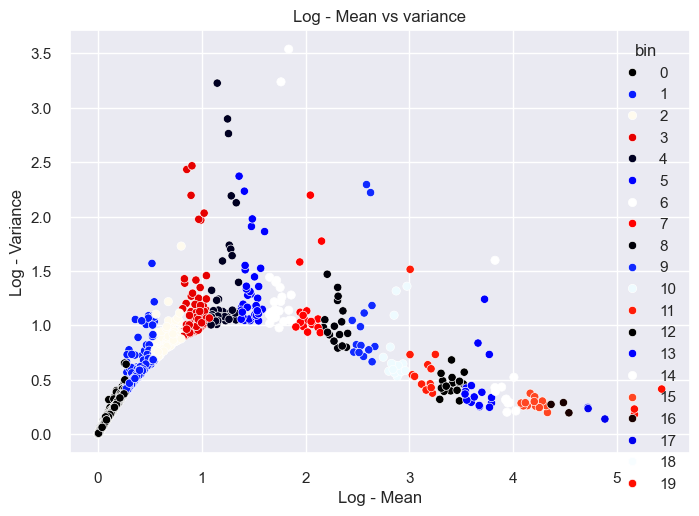

In [ ]:
sns.scatterplot(gene_df, x='mean', y='var', hue='bin', palette='flag')
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')

In [ ]:
# Find variance to mean ratio
gene_df['dispersion'] = gene_df['var'] / gene_df['mean']

In [ ]:
# Find mean and standard deviatiin
gene_df_grouped = gene_df.groupby('bin')['dispersion']
bin_means = gene_df_grouped.mean()
bin_stds = gene_df_grouped.std(ddof=1)

/var/folders/34/4mb6rzb52l76jcqm_pjx3fph0000gn/T/ipykernel_16138/2383709040.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df_grouped = gene_df.groupby('bin')['dispersion']


In [ ]:
# Normalize dispersion inside each bin
gene_df['dispersions_norm'] = (
    gene_df['dispersion'].to_numpy() - bin_means[gene_df['bin'].to_numpy()].to_numpy()
) / bin_stds[gene_df['bin'].to_numpy()].to_numpy()

In [ ]:
gene_df

,mean,var,bin,dispersion,dispersions_norm
AL627309.1,0.005960,0.009587,0,1.608566,-0.243072
RP11-206L10.2,0.002721,0.003890,0,1.429385,-1.523949
LINC00115,0.010918,0.018020,0,1.650493,0.056646
NOC2L,0.164018,0.256387,0,1.563165,-0.567622
KLHL17,0.005097,0.008295,0,1.627201,-0.109855
...,...,...,...,...,...
AL354822.1,0.004945,0.008120,0,1.642067,-0.003589
PNRC2,0.083301,0.130656,0,1.568474,-0.529669
PNRC2,0.070606,0.112246,0,1.589747,-0.377596
SRSF10,0.081779,0.131276,0,1.605262,-0.266688


Text(0, 0.5, 'Log - Custom dispersion')

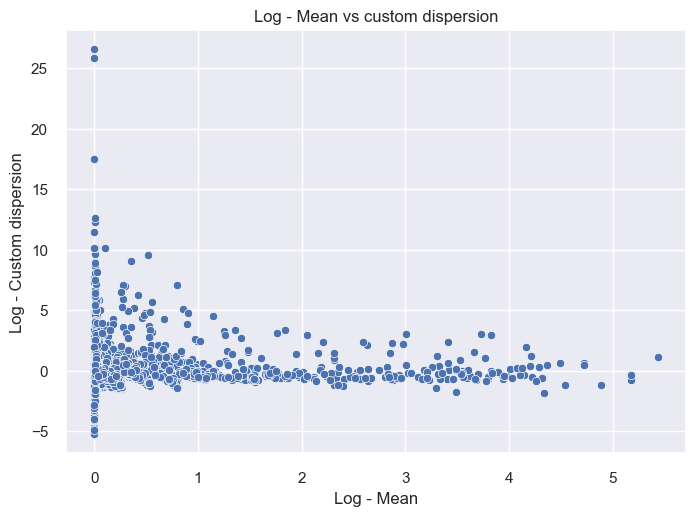

In [ ]:
sns.scatterplot(gene_df.reset_index(drop=True), x='mean', y='dispersions_norm')

plt.title('Log - Mean vs custom dispersion')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Custom dispersion')

In [ ]:
# Sort genes by coefficient of variation
gene_df = gene_df.sort_values('dispersions_norm', ascending=False)

# Keep 2000 genes with highest coefficient of variation
highly_variable_genes = gene_df.index[:2000]

# Subset the expression matrix to highly variable genes
expression_df = expression_df.loc[:, highly_variable_genes]

In [ ]:
expression_df

,MICALCL,GJC3,AARD,ARVCF,C2CD4D,TTC8,ARHGDIG,IGLL5,HIST1H1B,RP11-147L13.8,...,TUFT1,TMEM209,WWOX,KRT2,TCFL5,KCNH8,APLP2,ERCC8,C1orf112,TGFBR3
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACTGGTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGCATGAGAGGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.378132,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality reduction


In [ ]:
# Run PCA
pca = PCA()
pca_transformed_data = pca.fit_transform(expression_df.to_numpy())

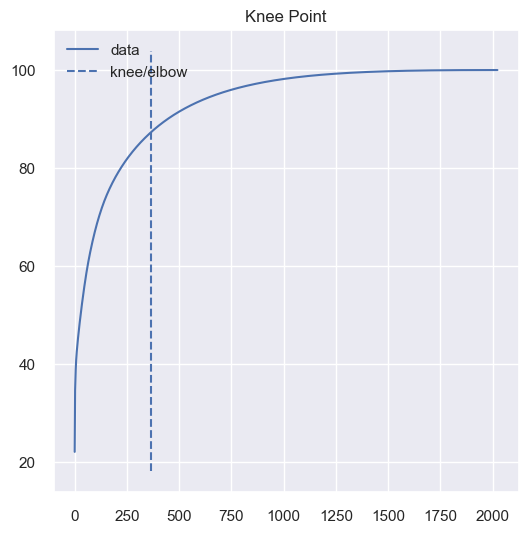

In [ ]:
# Perform knee detection
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)), 
    cumulative_explained_variance, 
    S=1.0, 
    curve="concave", 
    direction="increasing"
)
kneedle.plot_knee()

Number of principal components is choosen to be 50. This is frequent choice for this analysis type.

In [ ]:
# Extract subset of principal components
elbow_point = kneedle.elbow
pca_transformed_data = pca_transformed_data[:, :50]

In [ ]:
# Run umap 
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_transformed_data)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### Following peripheral blood mononuclear cells (PBMCs) are present in this dataset.


- **B Cells**
  - **What They Do**: Make "tags" (antibodies) that stick to germs and mark them for destruction.
  - **Main Role**: Help the immune system recognize and remember germs.
  - **Why Different**: Only cells that make antibodies to tag specific germs.

<!-- Empty Line After Main Bullet -->


- **Dendritic Cells (DCs)**
  - **What They Do**: Capture germs and show pieces to other immune cells.
  - **Main Role**: Alert the immune system about invaders.
  - **Why Different**: Messengers between the first-line and specialized immune defenses.

<!-- Empty Line After Main Bullet -->


- **CD14+ Monocytes**
  - **What They Do**: Suck up germs, break them apart, and can change into macrophages.
  - **Main Role**: Clean up and later transform into tissue-specific cells for ongoing defense.
  - **Why Different**: Versatile; can transform and become part of tissue defenses.

<!-- Empty Line After Main Bullet -->


- **Natural Killer (NK) cells**
  - **What They Do**: Patrol and kill infected or cancerous cells without needing specific tags.
  - **Main Role**: Quick response to a wide range of problems.
  - **Why Different**: Can act without needing to recognize specific germs.

<!-- Empty Line After Main Bullet -->


- **CD8 T cells**
  - **What They Do**: Directly kill infected or cancerous cells.
  - **Main Role**: Eliminate specifically tagged cells.
  - **Why Different**: The "assassins" that directly kill target cells.

<!-- Empty Line After Main Bullet -->


- **Naive CD4 T cells**
  - **What They Do**: Wait to be activated to fight specific germs.
  - **Main Role**: Ready to be trained for fighting specific invaders.
  - **Why Different**: Untrained soldiers waiting for their first mission.

<!-- Empty Line After Main Bullet -->


- **Memory CD4 T cells**
  - **What They Do**: Remember past germs and react faster next time.
  - **Main Role**: Quick response to known threats.
  - **Why Different**: The immune system's "record keepers."

<!-- Empty Line After Main Bullet -->

- **FCGR3A+ Monocytes**
  - **What They Do**: Work with antibodies to make them more effective at tagging germs.
  - **Main Role**: Boost the effectiveness of antibodies.
  - **Why Different**: Have a special "hook" (FCGR3A) that enhances their cooperation with antibodies.

<!-- Empty Line After Main Bullet -->


- **Platelets**
  - **What They Do**: Help blood to clot.
  - **Main Role**: Stop bleeding.
  - **Why Different**: Not directly involved in fighting germs but crucial for preventing blood loss.



<Axes: >

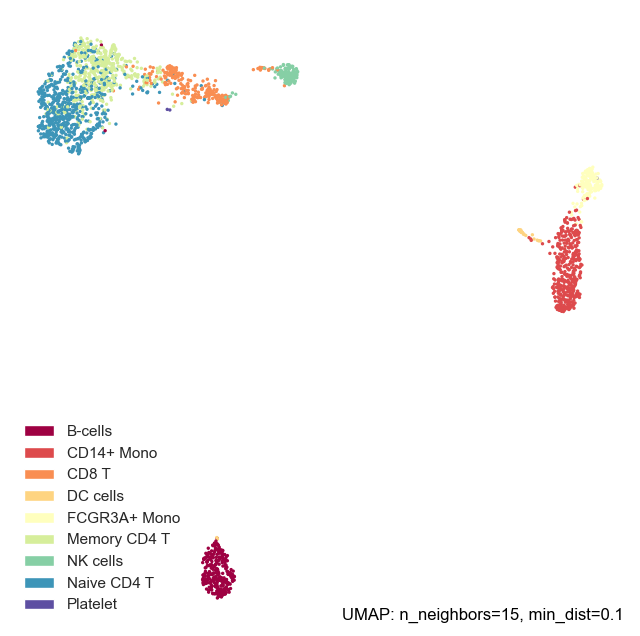

In [ ]:
# Plot umap embedding and display cell types
labels = [cell_type_dict[cell_id] if cell_id in cell_type_dict else 'none' for cell_id in expression_df.index ]
uplot.points(umap_obj, labels=np.array(labels))

## Attempt to cluster the data with K-means

In [ ]:
inertia_list = []
silhouette_score_list = []

# List used to store clusterings
clustering_result_dict = {}

# List used to store k means objects
k_means_list = []

num_clusters = range(3,15)

for num_clust in num_clusters:
    
    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto', random_state=42)
    kmeans.fit(pca_transformed_data)
    
    k_means_list.append(kmeans)
    
    # Calculate inertia
    inertia_list.append(kmeans.inertia_)
    
    # Add clustering result to list
    silhouette_scr = silhouette_score(pca_transformed_data, kmeans.labels_)
    silhouette_score_list.append(silhouette_scr)
    
    clustering_result_dict[num_clust] = np.array(kmeans.labels_)


Text(0, 0.5, 'Silhouette score value')

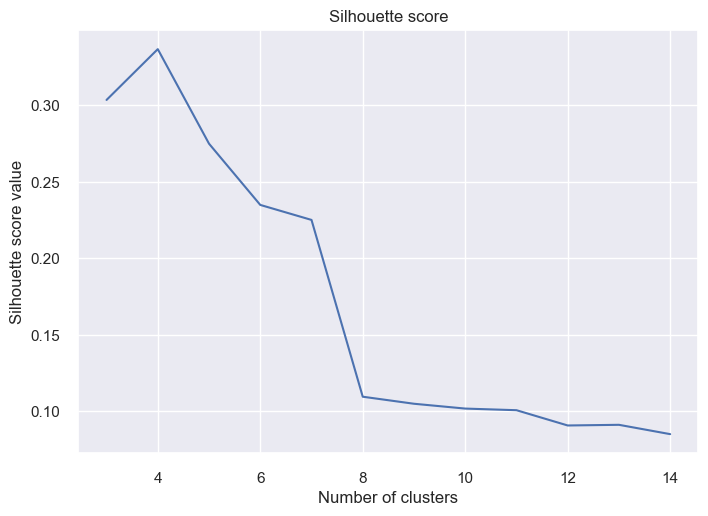

In [ ]:
# Siluethe plot
plt.plot(num_clusters, silhouette_score_list)
plt.title('Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')

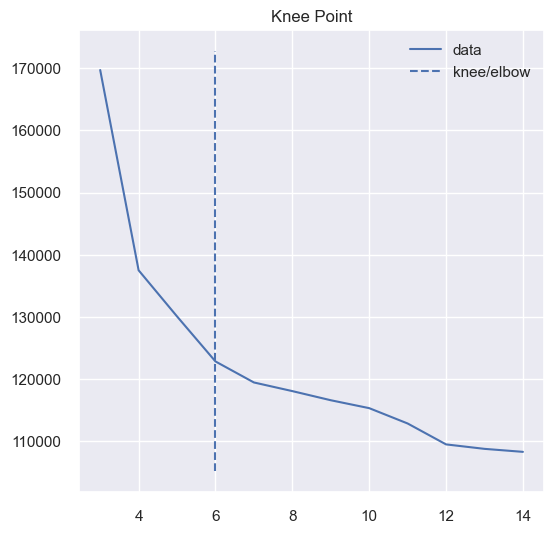

In [ ]:
# Plot inertia plot and curve
kneedle = KneeLocator(
    num_clusters, 
    inertia_list, 
    S=2, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

<Axes: >

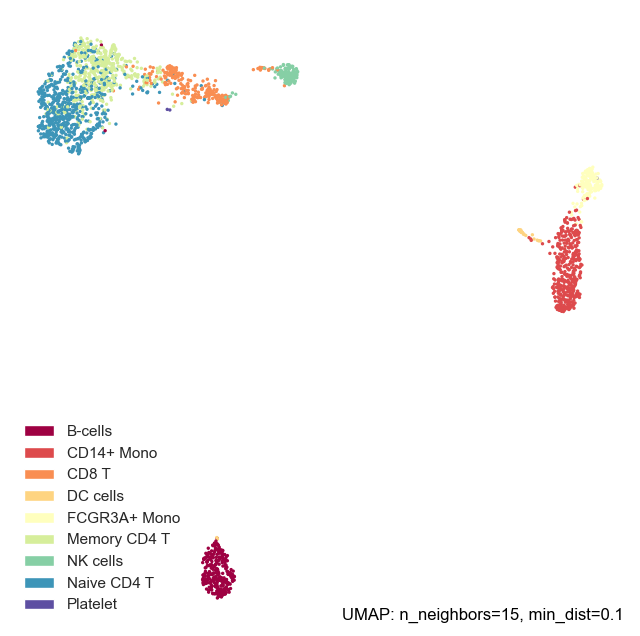

In [ ]:
uplot.points(umap_obj, labels=np.array(labels))

<Axes: >

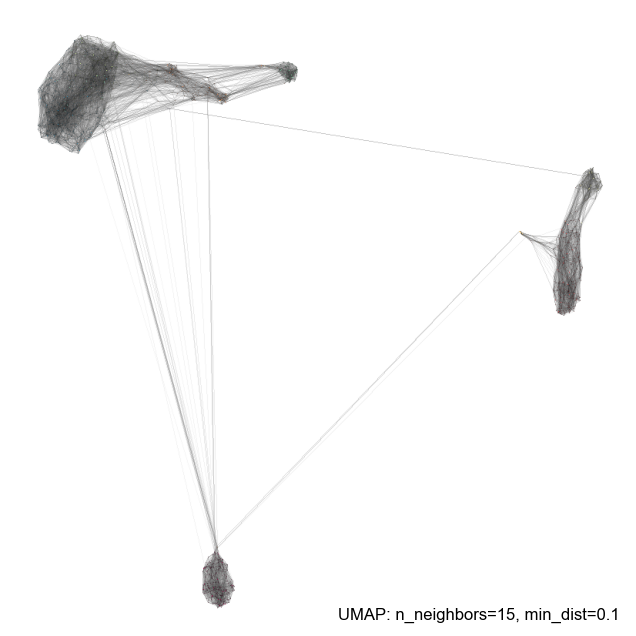

In [ ]:
umap.plot.connectivity(umap_obj, show_points=True,labels=np.array(labels))

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

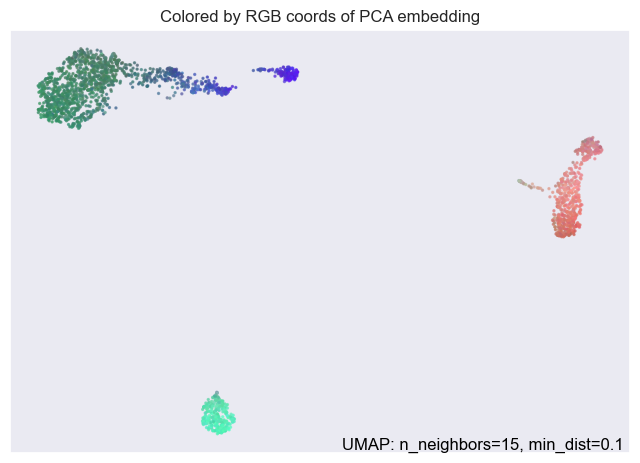

In [ ]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

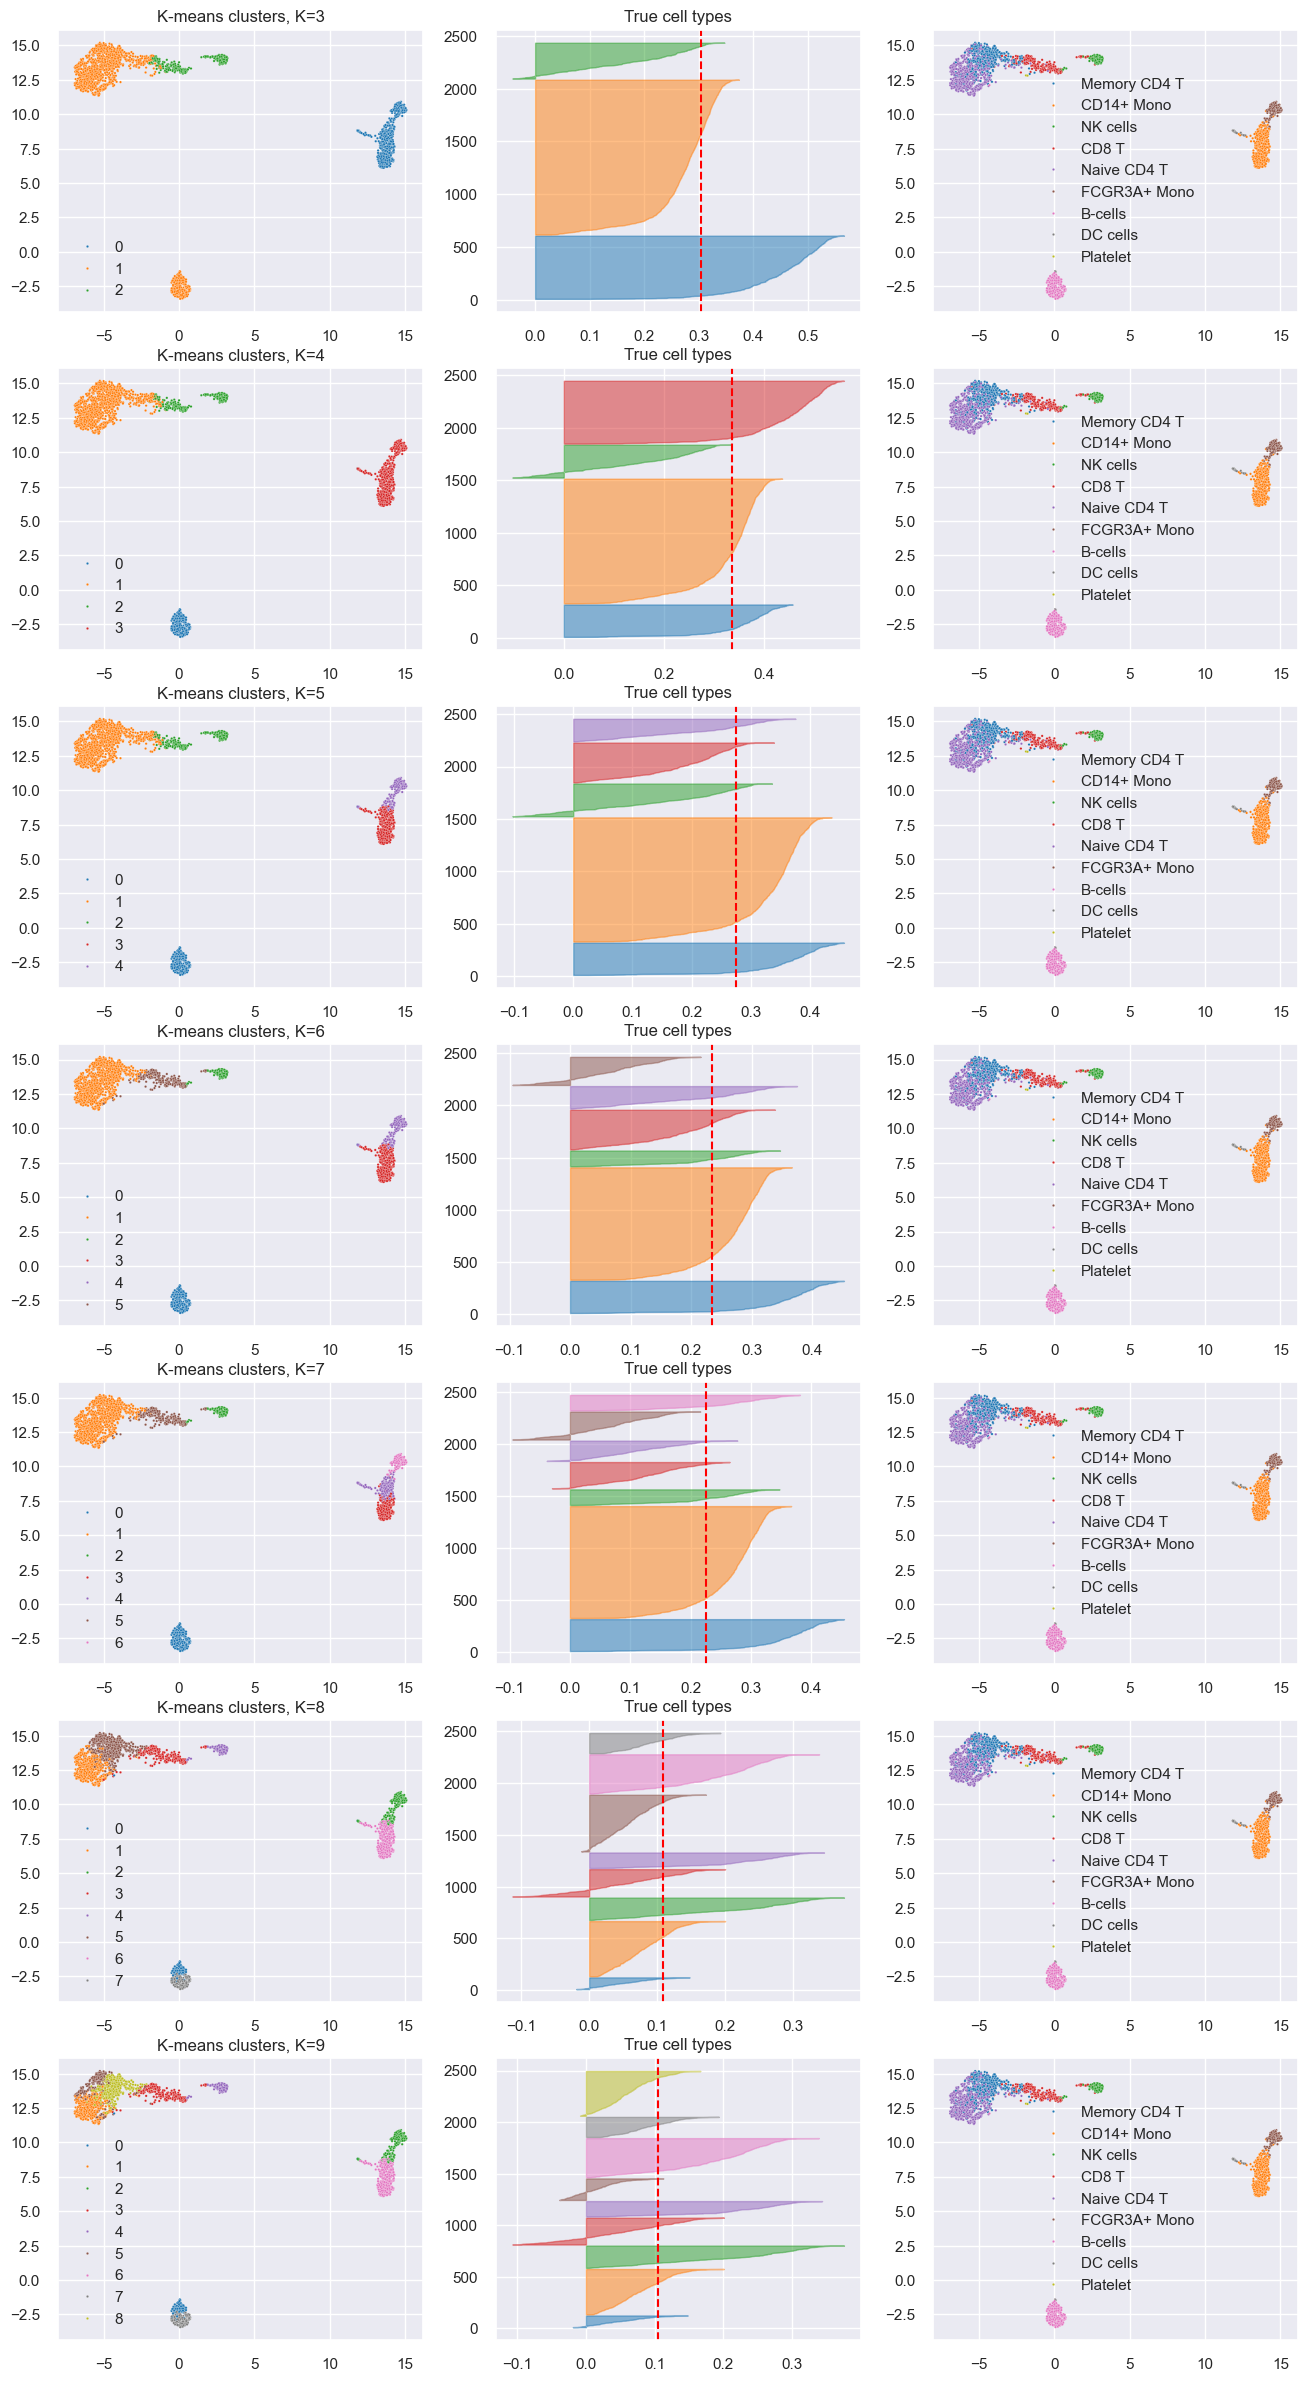

In [ ]:
num_clust_list = [3,4,5,6,7,8,9]

# Initialize the grid of plots
fig, axs = plt.subplots(
    len(num_clust_list), 3, 
    figsize=(16, 30)
)

tab10 = list(matplotlib.colormaps['tab10'].colors)

# Loop to populate the grid with plots
for i in range(len(num_clust_list)):

    sns.scatterplot(
        x=embedding[:,0], 
        y=embedding[:,1], 
        hue=clustering_result_dict[num_clust_list[i]], 
        ax=axs[i, 0], 
        s=3, palette='tab10'
    )
    
    visualizer = SilhouetteVisualizer(
        k_means_list[i], 
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1]
    )
    
    visualizer = visualizer.fit(pca_transformed_data)
        
    sns.scatterplot(
        x=embedding[:,0], 
        y=embedding[:,1], 
        hue=np.array(labels), 
        ax=axs[i, 2], 
        s=3, palette='tab10'
    )
    axs[i,0].set_title('K-means clusters, K={}'.format(num_clust_list[i]))
    axs[i,1].set_title('True cell types')

plt.show()


Text(0.5, 1.0, 'Adjusted rand score')

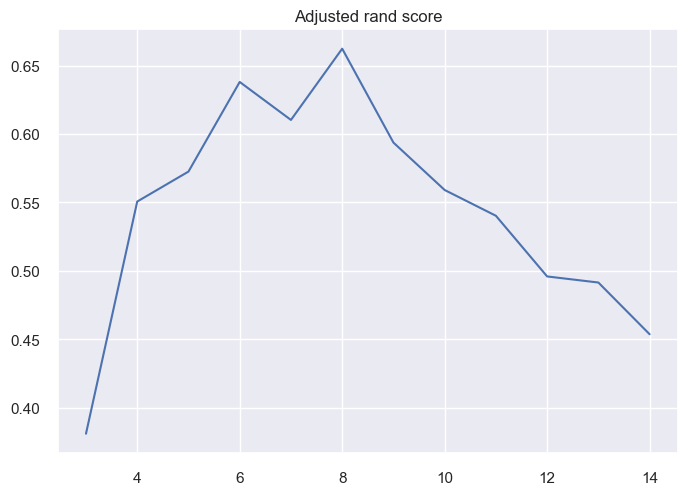

In [ ]:
adj_rand_score_list = []
for clust_num in clustering_result_dict:
    
    adj_rand_score_list.append(adjusted_rand_score(clustering_result_dict[clust_num], labels))
    
plt.plot(clustering_result_dict.keys(), adj_rand_score_list)
plt.title('Adjusted rand score')

### Describing the clusters - K=7

In [ ]:
# Get cells bellonging to cluster 0
current_clust = clustering_result_dict[7]
current_clust

bcells_idx = np.where(current_clust==0)
other_clust_idx = np.where(current_clust!=0)

In [66]:
full_expression_df

,AL627309.1,RP11-206L10.2,LINC00115,NOC2L,KLHL17,PLEKHN1,HES4,RP11-54O7.11,ISG15,AGRN,...,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2,PNRC2,SRSF10,SRSF10
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.635873,0.0,2.864242,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.429502,0.0,...,1.995141,0.0,2.617869,0.0,0.0,0.000000,1.429502,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.558310,0.0,...,2.149274,0.0,2.149274,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,3.063772,0.0,2.416278,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
AAACGCACTGGTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726902,0.0,...,0.000000,0.0,2.699321,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.725352,0.0,...,0.000000,0.0,1.358883,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.362331,0.0,...,1.362331,0.0,2.535374,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,3.208945,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
TTTGCATGAGAGGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,2.378132,0.0,0.0,2.378132,0.000000,0.0,0.0,0.0


In [85]:
full_expression_df['MT-ND5']

AAACATACAACCAC-1    1.635873
AAACATTGATCAGC-1    1.995141
AAACCGTGCTTCCG-1    2.149274
AAACCGTGTATGCG-1    3.063772
AAACGCACTGGTAC-1    0.000000
                      ...   
TTTCGAACTCTCAT-1    0.000000
TTTCTACTGAGGCA-1    1.362331
TTTCTACTTCCTCG-1    0.000000
TTTGCATGAGAGGC-1    0.000000
TTTGCATGCCTCAC-1    0.000000
Name: MT-ND5, Length: 2406, dtype: float64

In [59]:
from scipy.stats import mannwhitneyu

result_df = pd.DataFrame(columns=['ratio', 'pvalue'])

# Iterate through genes
for gene in full_expression_df.columns:
    
    # Get expression values for current gene
    curr_gene_exp = full_expression_df[gene].to_numpy()
    
    # Extract values belonging to cluster 6
    bcells_exp = curr_gene_exp[bcells_idx]
    # Extract values belonging to other clusters (all except cluster 6)
    other_exp = curr_gene_exp[other_clust_idx]
    
    # Find ratio of mean values
    mean_bcells = np.mean(bcells_exp) + 0.0001  # Add small value to avoid division by zero
    mean_others = np.mean(other_exp) + 0.0001
    
    ratio = mean_bcells/mean_others
    
    # Perform statistical testing
    ranksum_res = mannwhitneyu(bcells_exp, other_exp, alternative='greater')
    
    if ranksum_res.pvalue is not None:
        result_df.loc[gene, 'ratio'] = ratio
        result_df.loc[gene, 'pvalue'] = ranksum_res.pvalue

In [60]:
result_df['pvalue'] = pd.to_numeric(result_df['pvalue'], errors='coerce')

In [61]:
result_df.sort_values(['pvalue', 'ratio'], ascending=True).head(10)

,ratio,pvalue
CDKN1C,60.08483,2.072977e-216
RP11-290F20.3,14.519451,8.968331e-194
HES4,28.602386,1.961933e-190
MS4A7,14.126399,1.910287e-169
FCGR3A,9.473742,2.735303e-160
CKB,63.331277,1.276223e-152
LILRA3,17.411464,9.822946e-137
IFITM3,6.826376,3.200599e-133
LRRC25,10.783214,1.770488e-121
MS4A4A,27.443459,1.058426e-119


Text(0.5, 1.0, 'MS4A1 gene expression - B-cell marker')

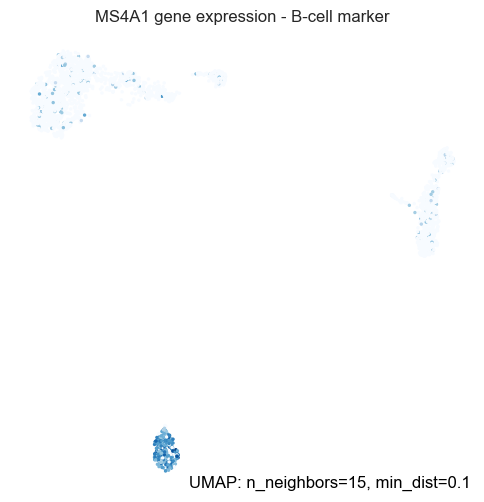

In [62]:
uplot.points(
    umap_obj, 
    values=full_expression_df['MS4A1'].to_numpy(), 
    width=600, height=600
)
plt.title('MS4A1 gene expression - B-cell marker')

Text(0.5, 1.0, 'CD79A gene expression - B-cell marker')

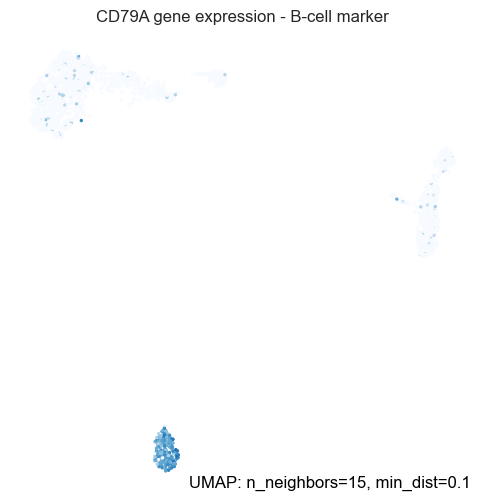

In [63]:
uplot.points(
    umap_obj, 
    values=full_expression_df['CD79A'].to_numpy(), 
    width=600, height=600
)
plt.title('CD79A gene expression - B-cell marker')